In [2]:
# !conda install -c conda-forge tqdm -n TORCH_ENV_NAME
# !pip install torchinfo

import os
import sys
sys.path.append('lib')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import utils
from utils import STOCKS_LIST
from stock_data import stock_data
from RNN import RNN


# Pre-training

## Set hyper parameters

STOCKS: name of stocks to be predicted -> Choose from data


PRECISON: precision of prediction -> 32/64


PRE_PROCESS: Whether to use pre-processed data from data_preprocessing.ipynb -> True/False


RNN_TYPE: type of rnn -> (bi)RNN, (bi)LSTM, (bi)GRU


IN_FEATURES/OUT_FEATURES: features to be input/output of machine -> Open, Close, High, Low


SCALER_NAME: Name of sklearn.preprocessing scaler -> MinMaxScaler, StandardScaler, RobustScaler,...


HIDDEN_SIZE: Size of hidden variables inside RNN/LSTM/GRU module


NUM_LAYERS: Number of stacked layers of RNN/LSTM/GRU module


DROPOUT: drop out rate of NN


PAST_DAYS: Number of days to be used to predict


SUCCESSIVE_DAYS: Number of days to be predicted


OPTIMIZER_NAME: Name of optimizer to be used -> RMSprop, Adam, Adagrad, ...


LEARNING_RATE: learning rate of optimizer


L2_REGULARIZATION: L2 regularization factor for optimizer


LOSS_NAME: Name of loss function -> MSELoss, SmoothL1Loss, ...


SCALER_NAME: name of scaler to normalize data -> 'MinMaxScaler'



In [21]:
#* Name of stock
STOCKS = "GOOGL"
if STOCKS not in STOCKS_LIST:
    raise Exception("Given stocks col_name is not valid")

#* Set default precision
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))

#* Whether to use pre-processed data
PRE_PROCESS = True

#* Recurrent Neural Network Type: Choosed between LSTM, GRU
RNN_TYPE = "RNN"

#* prefix of model name: Full information of model
PREFIX = '_'.join([STOCKS, PRECISION, RNN_TYPE]) + "_"

#* Take bi-directional
if "bi" in RNN_TYPE:
    RNN_TYPE = RNN_TYPE[2:]
    BIDIRECTIONAL = True
else:
    BIDIRECTIONAL = False

#* Features to use: Choose between 'Open', 'Close', 'High', 'Low'
IN_FEATURES = ['Open', 'Close', 'High', 'Low']
OUT_FEATURES = ['High', 'Low']
IN_FEATURES, OUT_FEATURES = utils.check_features(IN_FEATURES, OUT_FEATURES)

PREFIX += ''.join([feature[0] for feature in IN_FEATURES]) + '2' + ''.join([feature[0] for feature in OUT_FEATURES])

#* Scaler
SCALER_NAME = 'StandardScaler'
if SCALER_NAME != 'MinMaxScaler':
    PREFIX += "_SC{}".format(SCALER_NAME)

#* Hidden size of LSTM/GRU
HIDDEN_SIZE = 50
if HIDDEN_SIZE != 50:
    PREFIX += "_HS{}".format(HIDDEN_SIZE)

#* Number of stacked layers of LSTM/GRU
NUM_LAYERS = 4
if NUM_LAYERS != 4:
    PREFIX += "_NL{}".format(NUM_LAYERS)

#* Drop out
DROPOUT = 0.2
if DROPOUT:
    PREFIX += "_DO{:.2f}".format(DROPOUT)

#* Number of days to use prediction
PAST_DAYS = 65
if PAST_DAYS != 60:
    PREFIX += "_PD{}".format(PAST_DAYS)

#* Number of days to predict
SUCCESSIVE_DAYS = 5
if SUCCESSIVE_DAYS > 1:
    PREFIX += "_SD{}".format(SUCCESSIVE_DAYS)

#* Optimizer name
OPTIMIZER_NAME = 'RMSprop'
if OPTIMIZER_NAME != 'RMSprop':
    PREFIX += '_OP' + OPTIMIZER_NAME

#* Learning rate for optimizer
LEARNING_RATE = 5e-4
if LEARNING_RATE:
    PREFIX += "_LR{}".format(LEARNING_RATE)

#* Regularization for optimizer
L2_REGULARIZATION = 5e-4
if L2_REGULARIZATION:
    PREFIX += "_RG{}".format(L2_REGULARIZATION)

#* Loss function
LOSS_NAME = 'SmoothL1Loss'
if LOSS_NAME != 'MSELoss':
    PREFIX += "_LF{}".format(LOSS_NAME)

#* Early stopping patience
PATIENCE = 10

print("prefix:", PREFIX)

#* Check device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE


prefix: GOOGL_32_RNN_OHLC2HL_SCStandardScaler_DO0.20_PD65_SD5_LR0.0005_RG0.0005_LFSmoothL1Loss


device(type='cuda', index=0)

## Generate dataset

In [22]:
data = stock_data(STOCKS,
                  in_features=IN_FEATURES,
                  out_features=OUT_FEATURES,
                  past_days=PAST_DAYS,
                  scaler_name=SCALER_NAME,
                  precision=PRECISION, pre_process=PRE_PROCESS,
                  successive_days=SUCCESSIVE_DAYS,
                  use_stock_dataset=True,
                  verbose=True)
train_loader = data.get_train_loader(batch_size=64, num_workers=4)
val_loader = data.get_val_loader(batch_size=64)


Finished reading a file data/pre_32/GOOGL.parquet.snappy
-----------------------------
Number of train set: 1943 with input: torch.Size([65, 4]) output: torch.Size([5, 2])
Number of validation set: 500 with input: torch.Size([65, 4]) output: torch.Size([5, 2])
Number of test set: 499 with input: torch.Size([65, 4]) output: torch.Size([5, 2])


## Define neural network, loss function, optimizer type

In [23]:
#* Define model
model = RNN(rnn_type=RNN_TYPE,
            in_features=IN_FEATURES,
            out_features=OUT_FEATURES,
            successive_days=SUCCESSIVE_DAYS,
            hidden_size=HIDDEN_SIZE,
            bidirectional=BIDIRECTIONAL,
            dropout=DROPOUT).to(DEVICE)

#* Initialize epoch, loss, optimizer, loss function
epoch, min_val_loss = 0, np.Inf
train_loss_list, val_loss_list = np.array([]), np.array([])
optimizer = getattr(optim, OPTIMIZER_NAME)(params=model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=L2_REGULARIZATION)
if LOSS_NAME == 'SmoothL1Loss':
    loss_func = nn.SmoothL1Loss(reduction='sum', beta=0.7)
else:
    loss_func = getattr(nn, LOSS_NAME)(reduction='sum')

#* Summarize the model
example, _ = data.train_dataset[0]
utils.model_summary(model, input_size=example.shape, precision=PRECISION)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
├─RNN: 1-1                               [1, 65, 4]       [1, 65, 50]      --               18,100           1,150,500
|    └─weight_ih_l0                                                        [50, 4]
|    └─weight_hh_l0                                                        [50, 50]
|    └─weight_ih_l1                                                        [50, 50]
|    └─weight_hh_l1                                                        [50, 50]
|    └─weight_ih_l2                                                        [50, 50]
|    └─weight_hh_l2                                                        [50, 50]
|    └─weight_ih_l3                                                        [50, 50]
|    └─weight_hh_l3                                                        [50, 50]
├─Linear: 1-2                            [1, 50]          [1, 10]          [50, 10]        

## Load model if needed

In [8]:
#* Load model
epoch = 81

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
min_val_loss = val_loss_list[-1]
test_loss = checkpoint['test_loss']
print("Loaded model has average test loss: {:.6f}, recurrent test loss: {:.6f}".format(test_loss[0], test_loss[1]))

try:
    print("REMARK:", checkpoint['Remark'])
except KeyError:
    pass


Loaded model has average test loss: 0.011749, recurrent test loss: 0.001440
REMARK: Early stopped


# Training

In [24]:
new_train_loss_list, new_val_loss_list = utils.train(model,
                                                     max_epoch=100,
                                                     loss_func=loss_func,
                                                     optimizer=optimizer,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     early_stop_counter=PATIENCE,
                                                     min_val_loss=min_val_loss,
                                                     verbose=1)

if PATIENCE:
    model.load_state_dict(torch.load('model/early_stop.pth'))

best_epoch = np.argmin(np.ma.masked_where(new_val_loss_list == 0, new_val_loss_list))
if new_val_loss_list[best_epoch] >= min_val_loss:
    best_epoch = -1

epoch += best_epoch + 1
train_loss_list = np.concatenate((train_loss_list, new_train_loss_list[:best_epoch + 1 + PATIENCE]))
val_loss_list = np.concatenate((val_loss_list, new_val_loss_list[:best_epoch + 1 + PATIENCE]))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1	Validation loss decreased (inf --> 0.872340). Saving model
Epoch 2	Validation loss decreased (0.872340 --> 0.649523). Saving model
Epoch 3	Validation loss decreased (0.649523 --> 0.505068). Saving model
Epoch 4	Validation loss decreased (0.505068 --> 0.455166). Saving model
Epoch 5	Early Stopping counter: 1 out of 10
Epoch 6	Validation loss decreased (0.455166 --> 0.430818). Saving model
Epoch 7	Validation loss decreased (0.430818 --> 0.373753). Saving model
Epoch 8	Early Stopping counter: 1 out of 10
Epoch 9	Early Stopping counter: 2 out of 10
Epoch 10	Validation loss decreased (0.373753 --> 0.372062). Saving model
Epoch 11	Early Stopping counter: 1 out of 10
Epoch 12	Validation loss decreased (0.372062 --> 0.345991). Saving model
Epoch 13	Early Stopping counter: 1 out of 10
Epoch 14	Early Stopping counter: 2 out of 10
Epoch 15	Validation loss decreased (0.345991 --> 0.341164). Saving model
Epoch 16	Early Stopping counter: 1 out of 10
Epoch 17	Validation loss decreased (0.3411

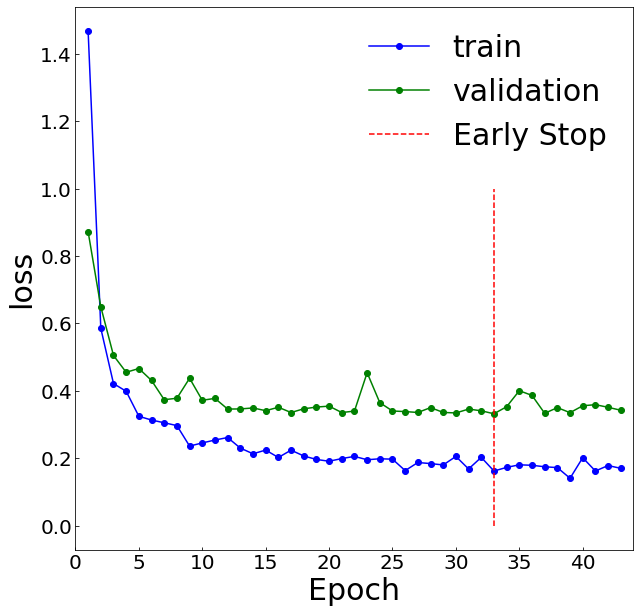

In [25]:
ax = utils.plot_loss(train_loss_list, val_loss_list, epoch)
_ = ax.set_xlim([0, epoch+PATIENCE+1])
# _ = ax.set_ylim([0, 0.03])

# Test

Average test finished with 1.61 seconds
Loss: 0.187166
Recurrent test finished with 1.55 seconds
Loss: 0.023040


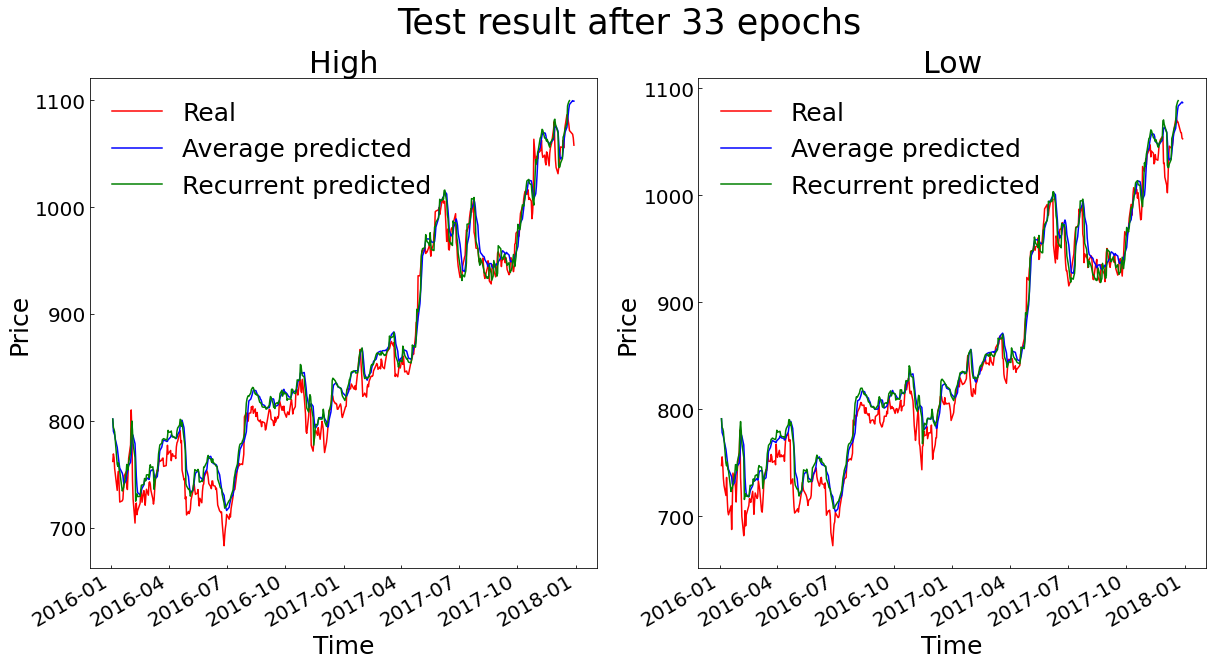

In [26]:
avg_prediction, avg_test_loss = utils.average_test(model, data,
                                                   loss_func=loss_func,
                                                   verbose=True)
recurrent_prediction, recurrent_test_loss = utils.recurrent_test(model, data,
                                                                 loss_func=loss_func,
                                                                 verbose=True)

ax = utils.plot_prediction(data=data,
                           epoch=epoch,
                           #   save_path=os.path.join('fig', PREFIX + "_prediction.png"),
                           avg_prediction=avg_prediction,
                           recurrent_prediction=recurrent_prediction)


# Save the model

In [27]:
#* Save the model with current state
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list[:epoch],
            'val_loss_list': val_loss_list[:epoch],
            'Remark': 'Early stopped',
            'test_loss': (avg_test_loss, recurrent_test_loss)},
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch)))